In [1]:
#importing libraries

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
import mysql.connector

In [2]:
#connecting to and querying the MySQL database
db_connection = mysql.connector.connect(
  host="",
  user="",
  passwd="",
  database="mps_data"
)
cursor = db_connection.cursor()

#extract and assign to a dataframe the data from the view 
#created previously in MySQL for inference purposes
query = '''
SELECT * FROM inference_view
WHERE Date_time BETWEEN '2021-04-01 00:00:00' AND '2022-03-31 23:59:59' AND
max_tactic != 0 AND
main_duty NOT IN ('Off duty', 'Custody');
'''
inference_view = pd.read_sql_query(query, db_connection)

C:\Users\Nikita\AppData\Local\Temp/ipykernel_3024/3264871683.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inference_view = pd.read_sql_query(query, db_connection)


In [3]:
inference_view.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130061 entries, 0 to 130060
Data columns (total 70 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date_time                     130061 non-null  datetime64[ns]
 1   year                          130061 non-null  int64         
 2   month                         130061 non-null  int64         
 3   day_of_month                  130061 non-null  int64         
 4   day_of_week                   130061 non-null  int64         
 5   hour_of_day                   130061 non-null  int64         
 6   minute_of_hour                130061 non-null  int64         
 7   is_weekend                    130061 non-null  int64         
 8   main_duty                     130061 non-null  object        
 9   ced_trained                   130061 non-null  float64       
 10  ced_carrying                  130061 non-null  float64       
 11  borough      

In [4]:
#create two groups for main_duty and borough based on the average max_tactic used in each group
#cut in performed at the median

avg_max_tactic_m = inference_view.groupby('main_duty')['max_tactic'].mean()
main_duty_bins = pd.qcut(avg_max_tactic_m.values, q=2)
duty_to_group = {duty: "MainDuty_" + str(group) for duty, group in zip(avg_max_tactic_m.index, main_duty_bins.codes + 1)}
inference_view['main_duty_group'] = inference_view['main_duty'].map(duty_to_group)
print(inference_view['main_duty_group'].value_counts())

avg_max_tactic_b = inference_view.groupby('borough')['max_tactic'].mean()
main_borough_bins = pd.qcut(avg_max_tactic_b.values, q=2)
borough_to_group = {borough: "Borough_" + str(group) for borough, group in zip(avg_max_tactic_b.index, main_borough_bins.codes + 1)}
inference_view['borough_group'] = inference_view['borough'].map(borough_to_group)
print(inference_view['borough_group'].value_counts())

print(pd.DataFrame.from_dict(duty_to_group, orient='index').sort_values(by=0, ascending=True))

main_duty_group
MainDuty_1    122815
MainDuty_2      7246
Name: count, dtype: int64
borough_group
Borough_2    66077
Borough_1    63984
Name: count, dtype: int64
                                 0
CID                     MainDuty_1
Foot patrol             MainDuty_1
Mobile patrol           MainDuty_1
Other                   MainDuty_1
Roads policing          MainDuty_1
Surveillance            MainDuty_1
AFO                     MainDuty_2
ARV                     MainDuty_2
CTSFO                   MainDuty_2
Dog handler duty        MainDuty_2
Mounted section duties  MainDuty_2
PSU/Public order        MainDuty_2


In [5]:
#define the list of all potential predictors to be used in the model
all_predictors = [
       'day_of_month', 'day_of_week', 'hour_of_day', 'minute_of_hour', 
       'is_weekend','ced_carrying', 'location_street',
       'location_pubtrans', 'location_retail', 'location_openground',
       'location_licensed', 'location_hospital', 'location_mentalhealth', 'primary_conduct',
       'officer_assaulted', 'impfct_weapon', 'impfct_alcohol', 'impfct_drugs',
       'impfct_mentalhealth', 'impfct_pknowledge', 'impfct_sizegenderbuild',
       'impfct_ABD', 'impfct_crowd', 'impfct_other', 'reason_protectself',
       'reason_protectpublic', 'reason_protectsubject',
       'reason_protectofficers', 'reason_preventoffence', 'reason_evidence',
       'reason_search', 'reason_arrest', 'reason_preventharm', 'reason_preventescape',
       'reason_other', 'assaulted_with_firearm', 'threatened_with_firearm',
       'assaulted_spit_throw', 'assaulted_bite', 'assaulted_without_weapon',
       'threatened_with_object', 'assaulted_with_object', 'is_staffinjured',
       'is_white', 'is_male', 'subject_age', 'physical_disability',
       'mental_disability', 'census_not_deprived', 'census_white_ethnic',
       'census_gay_lesbian', 'census_pop_density',
       'census_low_qualification', 'census_high_qualification',
       'census_born_uk', 'census_student', 'mps_crime_rate'
       ]

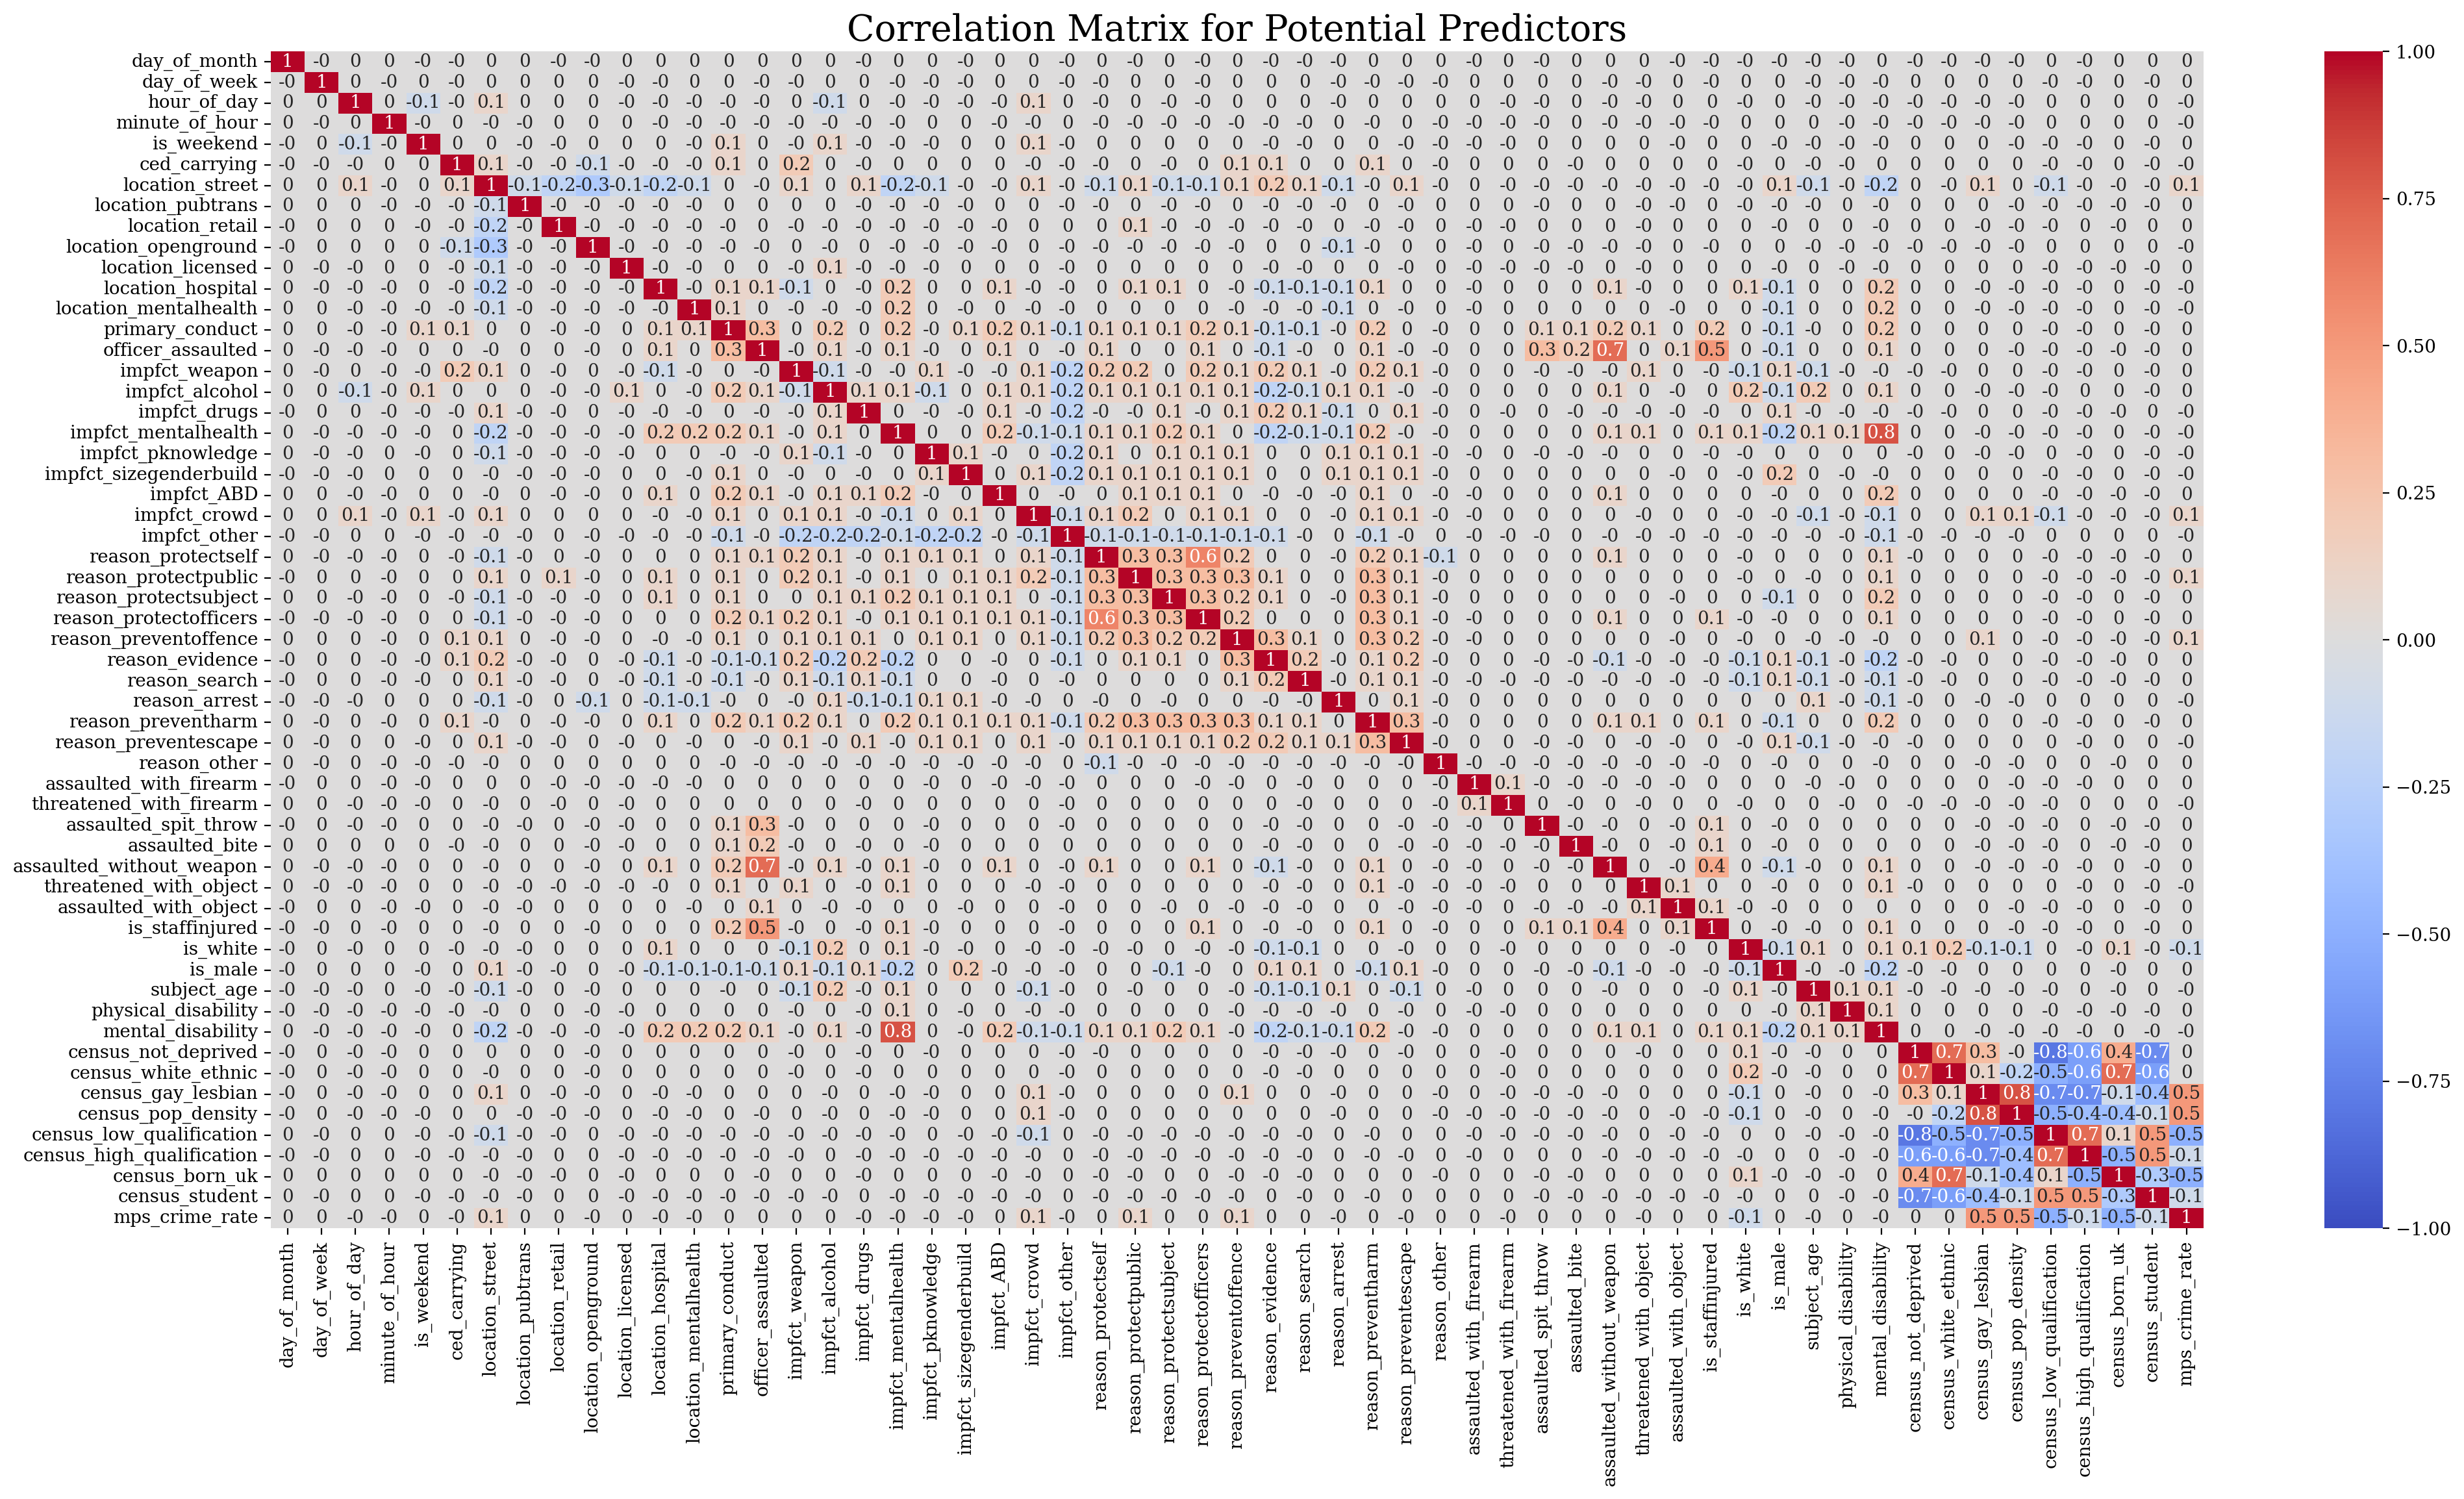

In [10]:
#display the correlation matrix for the potential variables

#compute the correlation matrix
correlation_matrix = np.round(inference_view[all_predictors].corr(), 1)
#plot the correlation matrix as a heatmap
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(24, 12), dpi=200)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
            vmin=-1, vmax=1)
plt.title('Correlation Matrix for Potential Predictors', fontsize=20)
plt.savefig('correlation_matrix_all.png')
plt.show()

In [5]:
#forward variable selection to gain initial idea (baseline) of statistically significant predictors using WLS

#define a list of included predictors
included_predictors = ['primary_conduct']
#initialize the variable to store the best score
best_score = np.inf
#p-value threshold for adding the variable
max_pvalue = 0.05

#frequency counts of a target variable
target_counts = inference_view['max_tactic'].value_counts()
#generate the inverse
inverse_freq = 1 / target_counts
#map the inverse frequencies to the target to get weights for WLS
weights = inference_view['max_tactic'].map(inverse_freq)

In [ ]:
#loop to find the best set of statistically significant predictors for the WLS model 

#suppress the warning for the chunk of code
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    #iterate until the loop is broken
    while True:
        changed = False
        excluded_predictors = list(set(all_predictors) - set(included_predictors))
        print("Attempting to add a new predictor")
        for predictor in excluded_predictors:
            #create a formula with a current potential predictor
            formula = 'max_tactic ~ ' + ' + '.join(included_predictors + [predictor])
            #fit the model 
            model = smf.wls(formula, data=inference_view, weights=weights)
            result = model.fit()
            #calculate the AIC score
            score = result.aic
            #get a p-value for a new potential predictor
            p_value = result.pvalues[predictor]
            #check that AIC is lower than the best_score and p-value is below threshold
            if score < best_score and p_value < max_pvalue:
                #check that other predictors remain significant after adding a new one
                all_predictors_significant = all([p < max_pvalue for p in result.pvalues[included_predictors]])
                #update the current best predictor
                if all_predictors_significant:
                    best_score = score
                    best_predictor = predictor
                    changed = True
                    print(f"Current best predictor: {best_predictor}, AIC: {best_score}, p-value: {p_value}")
                #if not all predictors are significant the remove insignificant
                else:
                    insignificant_predictors = [var for var, p in zip(included_predictors, result.pvalues[included_predictors]) if p >= max_pvalue]
                    for var in insignificant_predictors:
                        included_predictors.remove(var)
                    print(f"Removed insignificant predictors: {insignificant_predictors}")
                    #force loop to recheck after removing insignificant predictors
                    changed = True
                    break
        #if the appropriate predictor is found, add it to the included predictors list
        if changed and all_predictors_significant:
            included_predictors.append(best_predictor)
            print(f"Added predictor: {best_predictor}, Current AIC: {best_score}")
        else:
            print("No more predictors to add")
            break

Attempting to add a new predictor:
Current best predictor: location_street, AIC: 586937.5395099256, p-value: 1.43220394809116e-51
Current best predictor: reason_protectself, AIC: 579331.5355916114, p-value: 0.0
Current best predictor: impfct_weapon, AIC: 575414.0192417266, p-value: 0.0
Added predictor: impfct_weapon, Current AIC: 575414.0192417266
Attempting to add a new predictor:
Current best predictor: location_street, AIC: 575254.1728033046, p-value: 4.481691138255182e-37
Current best predictor: reason_protectself, AIC: 570919.4341811765, p-value: 0.0
Current best predictor: reason_arrest, AIC: 568802.5150277306, p-value: 0.0
Added predictor: reason_arrest, Current AIC: 568802.5150277306
Attempting to add a new predictor:
Current best predictor: location_street, AIC: 568562.933677834, p-value: 1.7868894397778373e-54
Current best predictor: reason_protectself, AIC: 564769.2652378913, p-value: 0.0
Current best predictor: ced_carrying, AIC: 564543.9896882565, p-value: 0.0
Added predic

In [6]:
included_predictors = ['primary_conduct',
 'impfct_weapon',
 'reason_arrest',
 'ced_carrying',
 'reason_protectself',
 'is_male',
 'officer_assaulted',
 'reason_preventescape',
 'reason_protectsubject',
 'impfct_sizegenderbuild',
 'threatened_with_object',
 'impfct_drugs',
 'census_born_uk',
 'reason_evidence',
 'is_staffinjured',
 'is_weekend',
 'impfct_other',
 'impfct_crowd',
 'location_street',
 'assaulted_with_object',
 'mps_crime_rate',
 'census_not_deprived',
 'reason_protectofficers',
 'census_white_ethnic',
 'location_openground',
 'mental_disability',
 'subject_age',
 'location_hospital',
 'reason_other',
 'physical_disability', 
 'assaulted_bite',
 'reason_search',
 'day_of_week',
 'location_pubtrans',
 'location_retail',
 'impfct_ABD',
 'reason_preventoffence',
 'reason_preventharm',
 'census_pop_density',
 'census_low_qualification',
 'hour_of_day',
 'impfct_pknowledge',
 'minute_of_hour',
 'day_of_month',
 'impfct_mentalhealth']

final_formula = 'max_tactic ~ ' + ' + '.join(included_predictors)

#fit a model with selected predictors
singlelevel_model = smf.wls(final_formula, data=inference_view, weights=weights)
singlelevel_model_result = singlelevel_model.fit()
singlelevel_model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             max_tactic   R-squared:                       0.563
Model:                            WLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     3727.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:45:32   Log-Likelihood:            -1.6363e+05
No. Observations:              130061   AIC:                         3.274e+05
Df Residuals:                  130015   BIC:                         3.278e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.3834      0.105     13.150      0.000       1.177       1.590
primary_conduct              0.4293      0.001    310.855      0.000       0.427       0.432
impfct_weapon                0.2117      0.005     42.471      0.000       0.202       0.221
reason_arrest                0.0621      0.004     14.100      0.000       0.054       0.071
ced_carrying                 0.0727      0.004     16.568      0.000       0.064       0.081
reason_protectself          -0.0135      0.006     -2.109      0.035      -0.026      -0.001
is_male                      0.0591      0.007      8.490      0.000       0.045       0.073
officer_assaulted            0.0965      0.011      8.885      0.000       0.075       0.118
reason_preventescape         0.0221      0.005      4.713      0.000       0.013       0.031
reason_protectsubject       -0.0807      0.005    -17.634      0.000      -0.090      -0.072
impfct_sizegenderbuild       0.0492      0.005     10.940      0.000       0.040       0.058
threatened_with_object       0.3152      0.012     25.980      0.000       0.291       0.339
impfct_drugs                -0.0298      0.005     -6.440      0.000      -0.039      -0.021
census_born_uk               0.0793      0.043      1.849      0.065      -0.005       0.163
reason_evidence              0.0261      0.005      5.297      0.000       0.016       0.036
is_staffinjured              0.1340      0.012     10.778      0.000       0.110       0.158
is_weekend                   0.0386      0.005      8.519      0.000       0.030       0.047
impfct_other                 0.1036      0.009     11.714      0.000       0.086       0.121
impfct_crowd                 0.0380      0.006      6.497      0.000       0.027       0.049
location_street              0.1050      0.005     20.470      0.000       0.095       0.115
assaulted_with_object       -0.4654      0.079     -5.918      0.000      -0.620      -0.311
mps_crime_rate              -0.2338      0.035     -6.745      0.000      -0.302      -0.166
census_not_deprived          0.1126      0.146      0.769      0.442      -0.174       0.399
reason_protectofficers       0.0327      0.006      5.703      0.000       0.021       0.044
census_white_ethnic          0.0601      0.037      1.626      0.104      -0.012       0.133
location_openground          0.1399      0.012     12.072      0.000       0.117       0.163
mental_disability           -0.0216      0.010     -2.167      0.030      -0.041      -0.002
subject_age                 -0.0178      0.003     -6.442      0.000      -0.023      -0.012
location_hospital           -0.1118      0.016     -7.122      0.000      -0.143      -0.081
reason_other                 0.7449      0.069     10.853      0.000       0.610       0.879
physical_disab

In [7]:
#create the grouping variable that combines two levels of grouping (since statsmodels doesn't support multiple grouping)
inference_view['combined_group'] = list(zip(inference_view.main_duty_group, inference_view.borough_group))

In [8]:
#create the MixedLM model manually selecting relevant features 
#(statistical significance changes once hierarchical structure is taken into account)

included_predictors = [
    'assaulted_bite',
    'assaulted_without_weapon',
    'assaulted_spit_throw',
    # 'assaulted_with_object',
    # 'census_born_uk',
    # 'census_not_deprived',
    # 'census_white_ethnic',
    # 'census_low_qualification',
    # 'np.log(census_no_heating)',
    'np.log(census_high_qualification)',
    # 'census_gay_lesbian',
    # 'census_pop_density',
    # 'np.log(census_student)',
    'ced_carrying',
    # 'hour_of_day',
    'impfct_alcohol',
    'impfct_crowd',
    'impfct_drugs',
    # 'impfct_mentalhealth',
    # 'impfct_other',
    # 'impfct_pknowledge',
    'impfct_sizegenderbuild',
    # 'impfct_ABD',
    'impfct_weapon',
    'is_male',
    'is_staffinjured',
    'is_white',
    # 'is_weekend',
    # 'location_hospital',
    # 'location_openground',
    'location_pubtrans',
    #  'location_retail',
    'location_street',
    'location_mentalhealth',
    # 'location_licensed',
    # 'np.log(mps_crime_rate)',
    'mental_disability',
    'officer_assaulted',
    # 'np.log1p(primary_conduct)',
    'primary_conduct',
    # 'physical_disability',
    # 'reason_arrest',
    'reason_evidence',
    # 'reason_other',
    'reason_protectself',
    'reason_preventescape',
    'reason_preventharm',
    'reason_preventoffence',
    'reason_protectofficers',
    'reason_protectsubject',
    'reason_search',
    #  'day_of_week',
    #  'day_of_month',
    'subject_age',
    # 'threatened_with_firearm'
]

included_predictors = sorted(included_predictors)
final_formula = 'max_tactic ~ ' + ' + '.join(included_predictors)

#fit the HLM model
model_22 = smf.mixedlm(final_formula, data=inference_view, groups=inference_view["combined_group"])
mixedlm_result_22 = model_22.fit()
mixedlm_result_22.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                   MixedLM       Dependent Variable:       max_tactic  
No. Observations:        130061        Method:                   REML        
No. Groups:              4             Scale:                    0.4466      
Min. group size:         3215          Log-Likelihood:           -132249.4176
Max. group size:         62046         Converged:                Yes         
Mean group size:         32515.2                                             
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          1.340    0.089  15.014 0.000  1.165  1.515
assaulted_bite                    -0.257    0.051  -5.026 0.000 -0.357 -0.157
assaulted_spit_throw              -0.110    0.035  -3.183 0.001 -0.177 -0.042
assaulted_without_weapon          -0.114    0.023  -4.998 0.000 -0.158 -0.069
ced_carrying                       0.099    0.004  24.466 0.000  0.091  0.107
impfct_alcohol                     0.060    0.005  12.657 0.000  0.051  0.070
impfct_crowd                       0.064    0.005  11.647 0.000  0.053  0.075
impfct_drugs                      -0.023    0.004  -5.735 0.000 -0.031 -0.015
impfct_sizegenderbuild             0.019    0.004   4.649 0.000  0.011  0.026
impfct_weapon                      0.074    0.005  15.701 0.000  0.064  0.083
is_male                           -0.070    0.006 -11.871 0.000 -0.082 -0.059
is_staffinjured                    0.080    0.015   5.194 0.000  0.050  0.110
is_white                          -0.013    0.004  -3.377 0.001 -0.021 -0.006
location_mentalhealth              0.126    0.025   5.015 0.000  0.077  0.176
location_pubtrans                  0.093    0.019   5.004 0.000  0.057  0.130
location_street                    0.045    0.004  10.852 0.000  0.036  0.053
mental_disability                  0.093    0.006  15.742 0.000  0.082  0.105
np.log(census_high_qualification) -0.040    0.014  -2.896 0.004 -0.068 -0.013
officer_assaulted                  0.146    0.019   7.579 0.000  0.108  0.183
primary_conduct                    0.366    0.001 272.824 0.000  0.363  0.368
reason_evidence                   -0.022    0.005  -4.969 0.000 -0.031 -0.014
reason_preventescape              -0.013    0.004  -3.200 0.001 -0.021 -0.005
reason_preventharm                 0.064    0.004  14.860 0.000  0.056  0.073
reason_preventoffence              0.069    0.004  16.559 0.000  0.061  0.077
reason_protectofficers             0.074    0.005  14.426 0.000  0.064  0.084
reason_protectself                -0.073    0.006 -13.204 0.000 -0.084 -0.062
reason_protectsubject             -0.015    0.004  -3.668 0.000 -0.023 -0.007
reason_search                     -0.033    0.005  -6.595 0.000 -0.043 -0.023
subject_age                       -0.014    0.002  -5.793 0.000 -0.019 -0.009
Group Var                          0.022    0.028                            
=============================================================================

"""

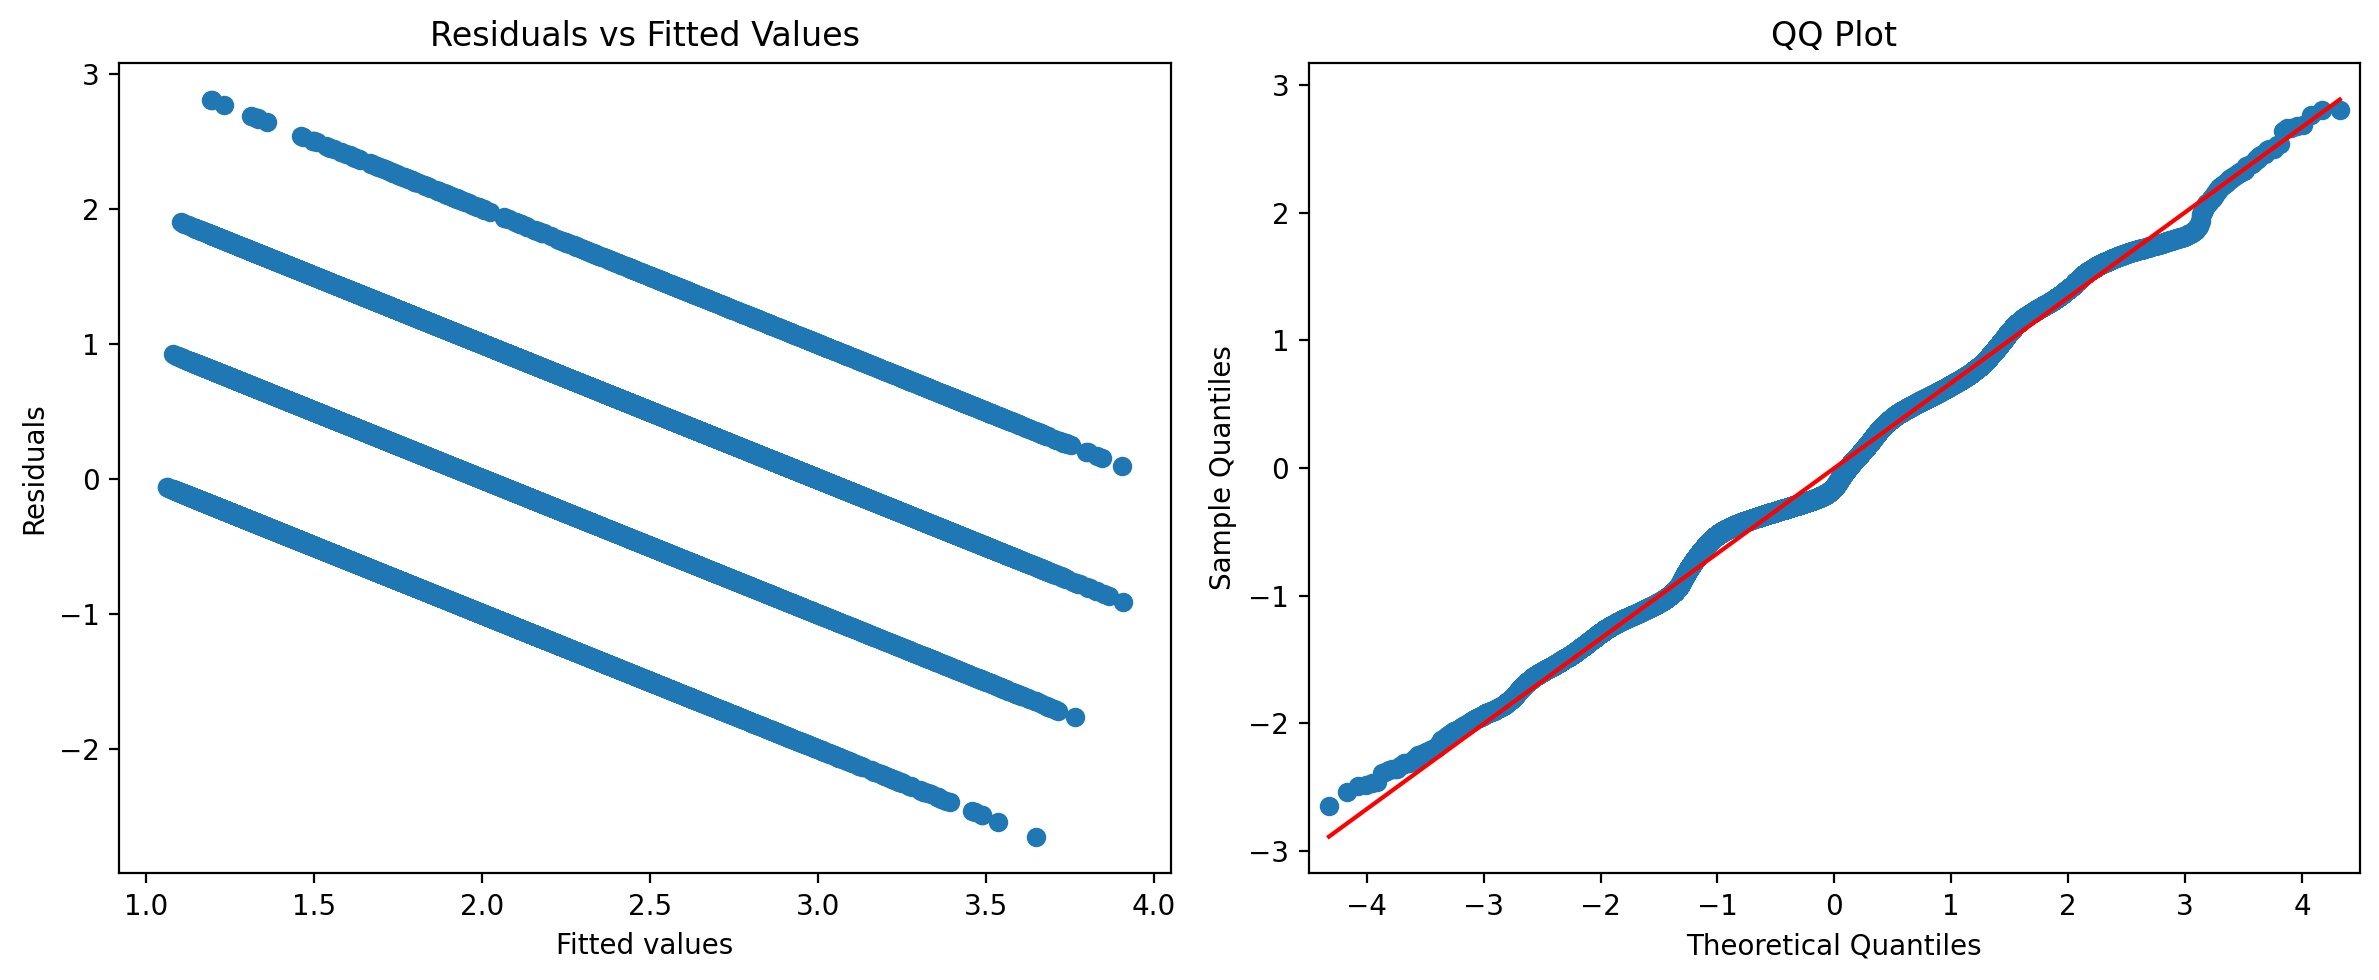

In [9]:
#performing assumption testing for the MixedLM model

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
#1. Homoscedasticity (residuals vs fitted values)
axes[0].scatter(mixedlm_result_22.fittedvalues, mixedlm_result_22.resid)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")
#2. Normality of residuals (QQ plot)
sm.qqplot(mixedlm_result_22.resid, line='s', ax=axes[1])
axes[1].set_title("QQ Plot")

plt.tight_layout()
plt.savefig("mixedlm_assumption_testing_1.png")
plt.show()

In [10]:
mixedlm_result_22.random_effects

{('MainDuty_1',
  'Borough_1'): Group   -0.138848
 dtype: float64,
 ('MainDuty_1',
  'Borough_2'): Group   -0.109657
 dtype: float64,
 ('MainDuty_2',
  'Borough_1'): Group    0.124141
 dtype: float64,
 ('MainDuty_2',
  'Borough_2'): Group    0.124365
 dtype: float64}

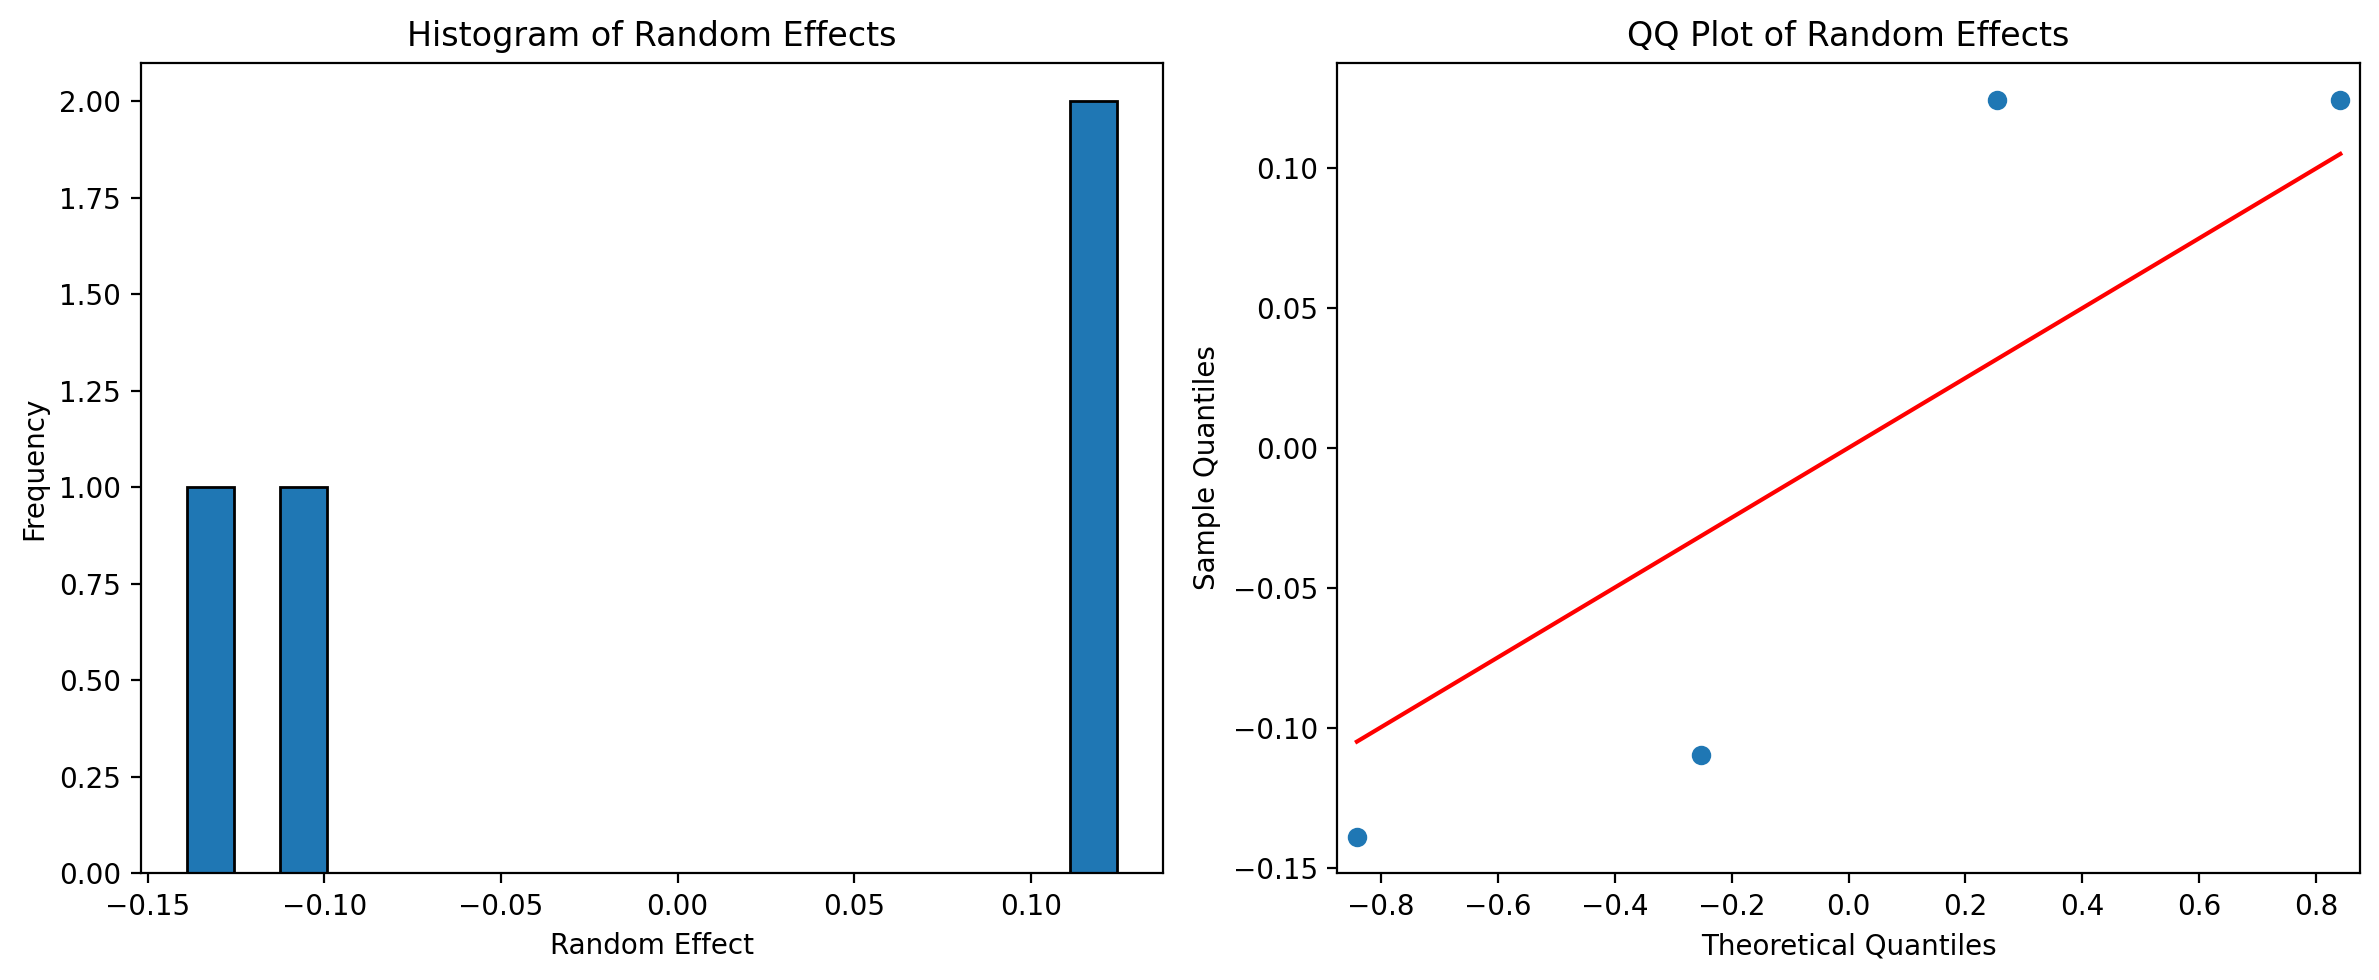

In [11]:
#combine random effects
combined_random_effects = [re[0] for re in mixedlm_result_22.random_effects.values()]
#create a plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
#1. Normality of random effects (histrogram of random effects)
axes[0].hist(combined_random_effects, bins=20, edgecolor='k')
axes[0].set_title("Histogram of Random Effects")
axes[0].set_xlabel("Random Effect")
axes[0].set_ylabel("Frequency")
#2. Normality of random effects (QQ plot of random effects)
sm.qqplot(np.array(combined_random_effects), line='s', ax=axes[1])
axes[1].set_title("QQ Plot of Random Effects")

plt.tight_layout()
plt.savefig("mixedlm_assumption_testing_2.png")
plt.show()

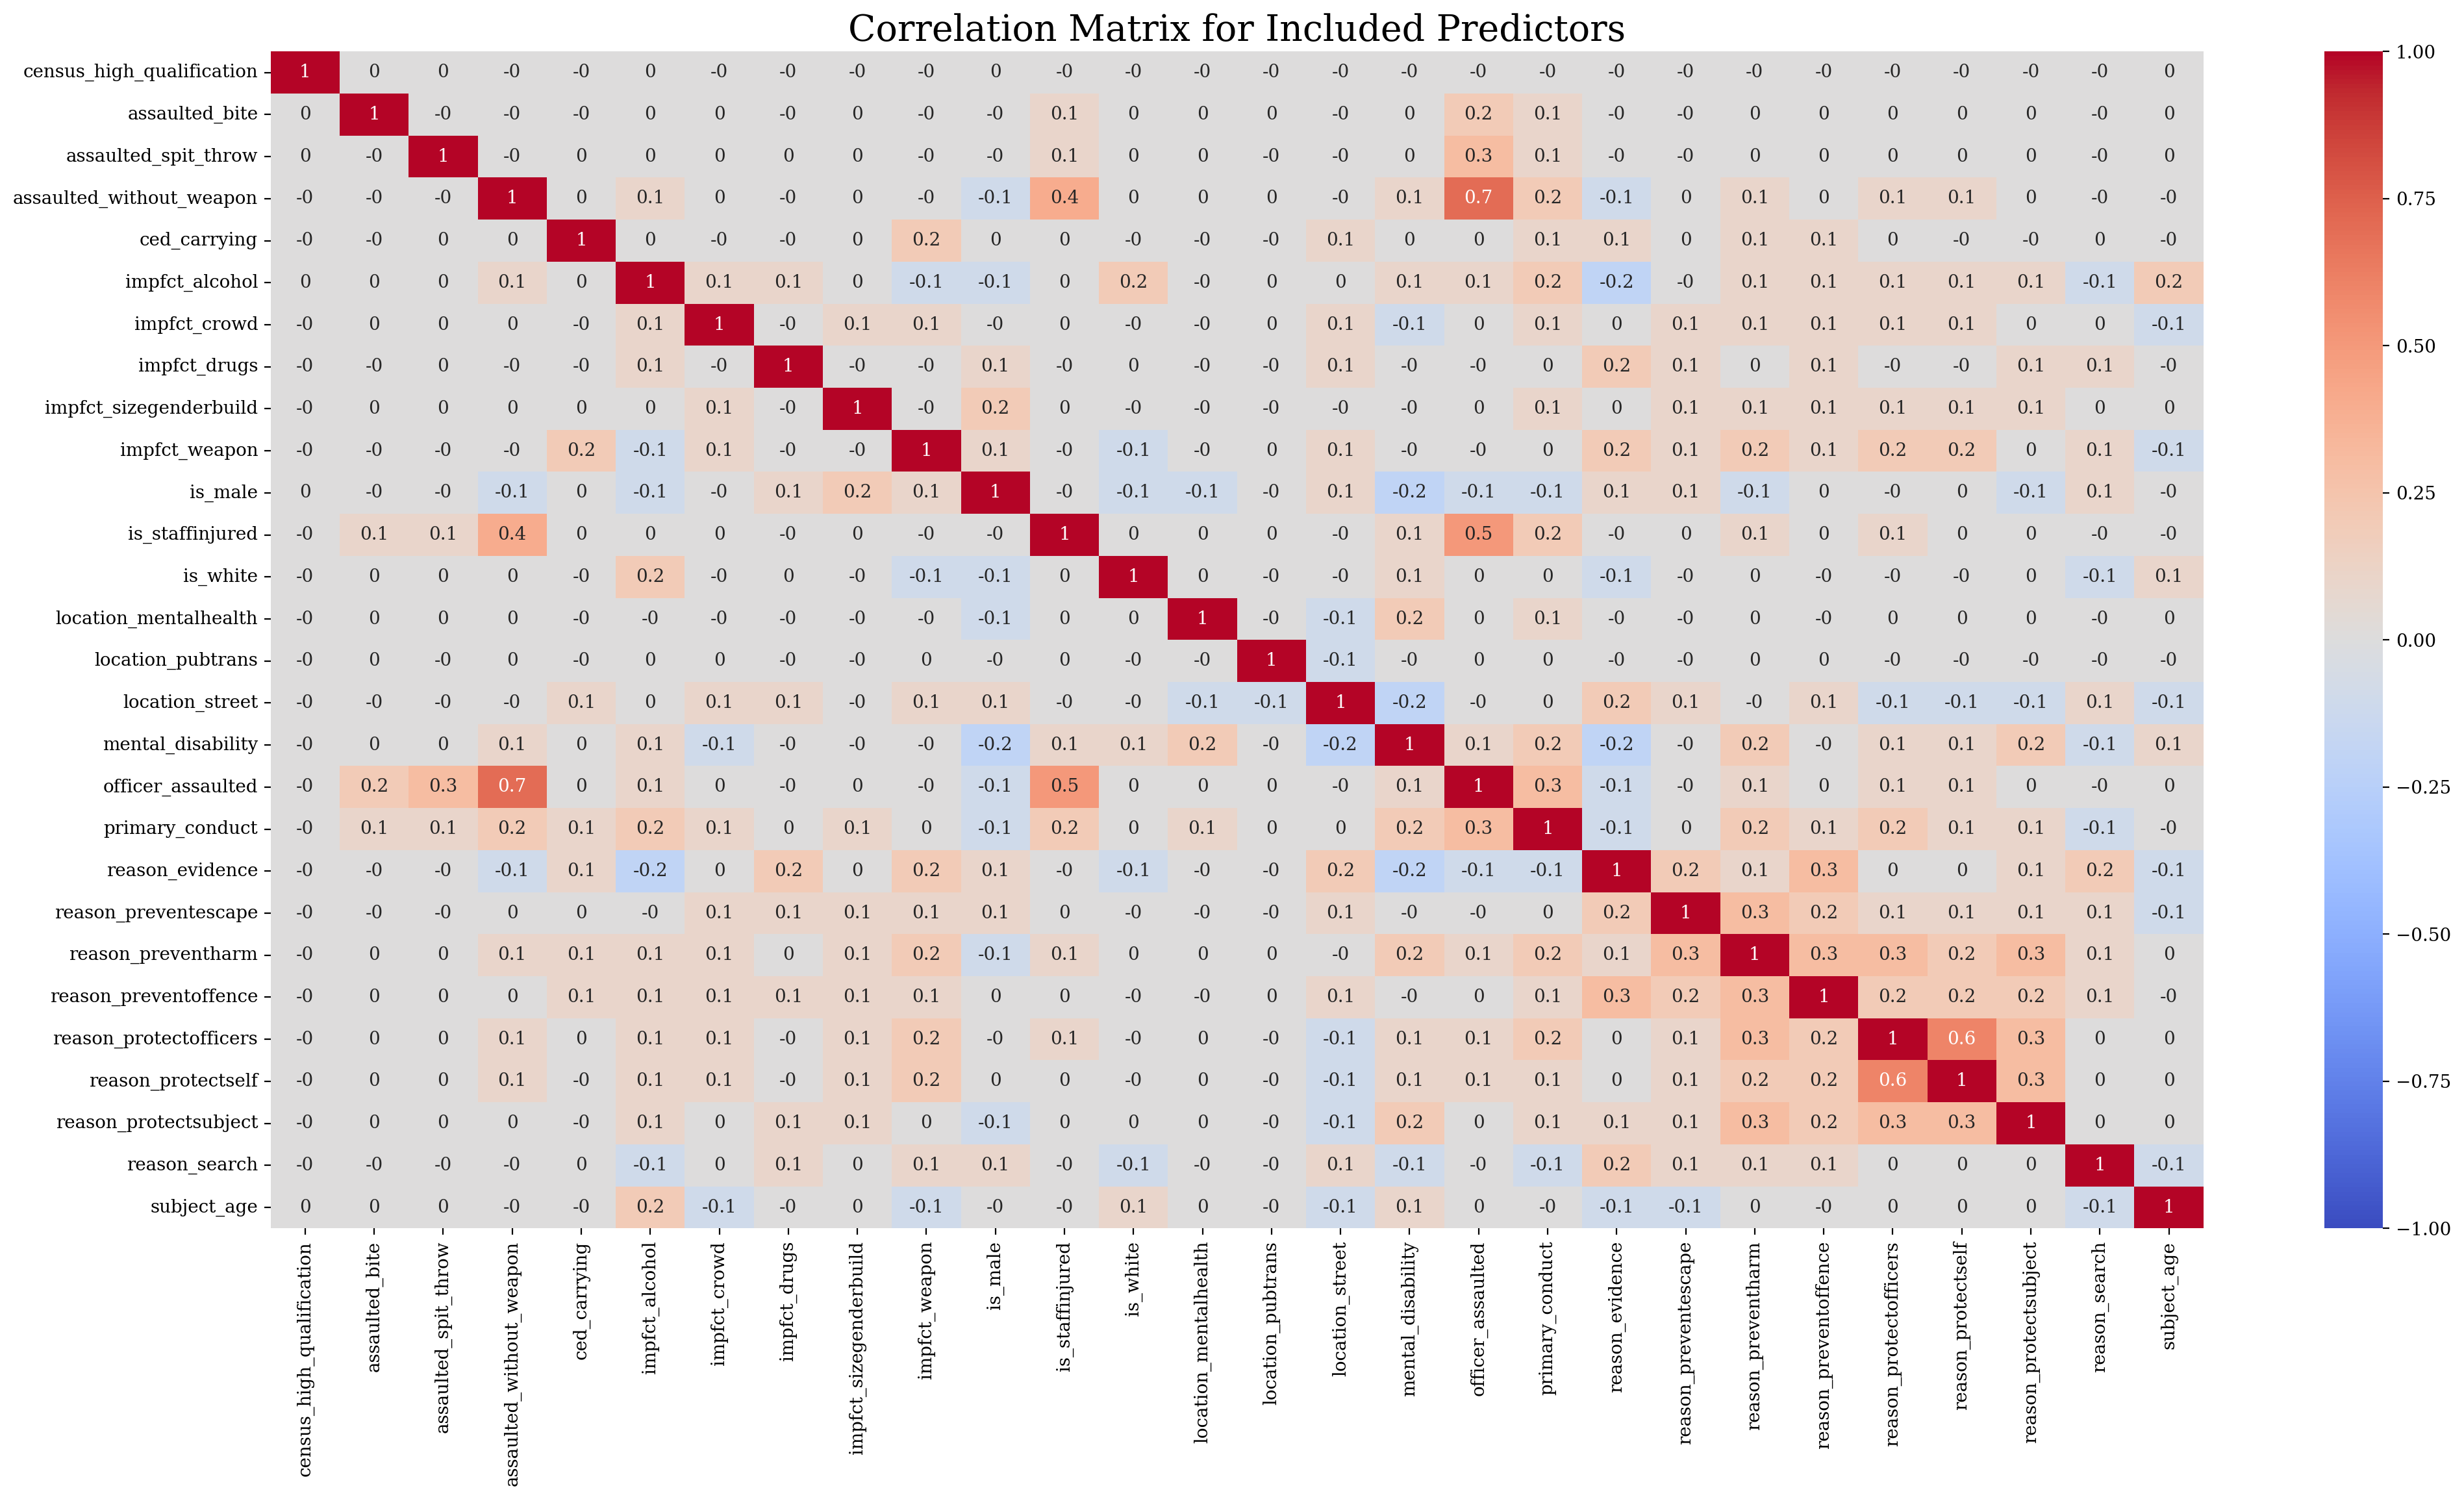

In [12]:
#plot the correlation matrix for the included predictors

included_predictors.remove('np.log(census_high_qualification)')
included_predictors.insert(0,'census_high_qualification')
selected_columns = inference_view[included_predictors]

correlation_matrix = np.round(selected_columns.corr(), 1)

plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(24, 12), dpi=200)
sns.heatmap(correlation_matrix, annot=True, 
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Included Predictors', fontsize=20)
plt.savefig('mixedlm_assumption_testing_corr.png')
plt.show()

In [13]:
#inserting the result of the main model for inference (22-21) into the database

#create the table to store the results
cursor.execute("""
        CREATE TABLE IF NOT EXISTS rq1_inference_result (
            id INT NOT NULL AUTO_INCREMENT,
            predictor VARCHAR(255),
            coefficient_22_21 FLOAT,
            p_value_22_21 FLOAT,
            t_test_22_21 FLOAT,
            coefficient_21_20 FLOAT,
            p_value_21_20 FLOAT,
            t_test_21_20 FLOAT,
            coefficient_20_19 FLOAT,
            p_value_20_19 FLOAT,
            t_test_20_19 FLOAT,
            PRIMARY KEY (id) );
""")

#insert the predictor names into the table
for element in mixedlm_result_22.params.index.to_numpy():
    query = "INSERT INTO rq1_inference_result (predictor) VALUES (%s);"
    cursor.execute(query, (element,))

#commit the transaction
db_connection.commit()

In [14]:
#inserting the model coefficients into the database
data = [(float(val), index) for val, index in zip(mixedlm_result_22.params.to_numpy(), mixedlm_result_22.params.index.to_numpy())]
cursor.executemany("UPDATE rq1_inference_result SET coefficient_22_21 = %s WHERE predictor = %s", data)

#inserting variable p-values into the database
data = [(float(val), index) for val, index in zip(mixedlm_result_22.pvalues.to_numpy(), mixedlm_result_22.pvalues.index.to_numpy())]
cursor.executemany("UPDATE rq1_inference_result SET p_value_22_21 = %s WHERE predictor = %s", data)

#insert z-statistics into the database
data = [(float(val), index) for val, index in zip(mixedlm_result_22.tvalues.to_numpy(), mixedlm_result_22.tvalues.index.to_numpy())]
cursor.executemany("UPDATE rq1_inference_result SET t_test_22_21 = %s WHERE predictor = %s", data)

#commit the transaction
db_connection.commit()

In [15]:
#extract the testing data from the database to test the model performance on unseen data
query = '''
SELECT * FROM inference_view
WHERE Date_time BETWEEN '2021-01-01 00:00:00' AND '2021-03-31 23:59:59' AND
max_tactic != 0 AND
main_duty NOT IN ('Off duty', 'Custody');
'''
inference_view_test = pd.read_sql_query(query, db_connection)

#bin the main duty and borough into previously defined bins
inference_view_test['main_duty_group'] = inference_view_test['main_duty'].map(duty_to_group)
inference_view_test['borough_group'] = inference_view_test['borough'].map(borough_to_group)

#create a new variable that combines the two groups
inference_view_test['combined_group'] = list(zip(inference_view_test.main_duty_group, inference_view_test.borough_group))

#display the number of observations in each group
print(inference_view_test['borough_group'].value_counts())
print(inference_view_test['main_duty_group'].value_counts())
print(inference_view_test['combined_group'].value_counts())

C:\Users\Nikita\AppData\Local\Temp/ipykernel_3024/4045474360.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inference_view_test = pd.read_sql_query(query, db_connection)


borough_group
Borough_1    18487
Borough_2    18413
Name: count, dtype: int64
main_duty_group
MainDuty_1    34998
MainDuty_2     1902
Name: count, dtype: int64
combined_group
(MainDuty_1, Borough_1)    17604
(MainDuty_1, Borough_2)    17394
(MainDuty_2, Borough_2)     1019
(MainDuty_2, Borough_1)      883
Name: count, dtype: int64


In [13]:
inference_view_test['predicted_max_tactic'] = mixedlm_result_22.predict(inference_view_test)
y_pred = inference_view_test['predicted_max_tactic']
y_true = inference_view_test['max_tactic']

#compute the R2 score for the test set
from sklearn.metrics import r2_score
print("R^2 score: ", np.round(r2_score(y_true, y_pred), 3))

from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", np.round(mean_absolute_error(y_true, y_pred),3))
print("Mean Squared Error: ", np.round(mean_squared_error(y_true, y_pred),3))
print("Mean Absolute Percentage Error: ", np.round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 3))

R^2 score:  0.469
Mean Absolute Error:  0.554
Mean Squared Error:  0.447
Mean Absolute Percentage Error:  38.837


In [14]:
#display performance metrics as if we consider it as a multi-class classification problem

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

#rounding off the predictions to the nearest integer
y_pred_rounded = np.round(y_pred)

print("Accuracy: ", np.round(accuracy_score(y_true, y_pred_rounded), 3) )
print("Precision: ", np.round(precision_score(y_true, y_pred_rounded, average='weighted'), 3))
print("Recall: ", np.round(recall_score(y_true, y_pred_rounded, average='weighted'), 3))
print("Confusion Matrix: \n", confusion_matrix(y_true, y_pred_rounded))
print(classification_report(y_true, y_pred_rounded))

Accuracy:  0.585
Precision:  0.695
Recall:  0.585
Confusion Matrix: 
 [[9240 6973  497    6]
 [2027 3890 1039   30]
 [ 349 3713 8386  288]
 [   3   62  337   60]]
              precision    recall  f1-score   support

           1       0.80      0.55      0.65     16716
           2       0.27      0.56      0.36      6986
           3       0.82      0.66      0.73     12736
           4       0.16      0.13      0.14       462

    accuracy                           0.58     36900
   macro avg       0.51      0.47      0.47     36900
weighted avg       0.69      0.58      0.62     36900



In [16]:
#extract the training data from the database for the model for 2021-2020

query = '''
SELECT * FROM inference_view
WHERE Date_time BETWEEN '2020-04-01 00:00:00' AND '2021-03-31 23:59:59' AND
max_tactic != 0 AND
main_duty NOT IN ('Off duty', 'Custody');
'''
inference_view = pd.read_sql_query(query, db_connection)

inference_view['main_duty_group'] = inference_view['main_duty'].map(duty_to_group)
inference_view['borough_group'] = inference_view['borough'].map(borough_to_group)

inference_view['combined_group'] = list(zip(inference_view.main_duty_group, inference_view.borough_group))

print(inference_view['borough_group'].value_counts())
print(inference_view['main_duty_group'].value_counts())
print(inference_view['combined_group'].value_counts())

C:\Users\Nikita\AppData\Local\Temp/ipykernel_3024/59076200.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inference_view = pd.read_sql_query(query, db_connection)


borough_group
Borough_1    78204
Borough_2    78130
Name: count, dtype: int64
main_duty_group
MainDuty_1    147466
MainDuty_2      8868
Name: count, dtype: int64
combined_group
(MainDuty_1, Borough_1)    74170
(MainDuty_1, Borough_2)    73296
(MainDuty_2, Borough_2)     4834
(MainDuty_2, Borough_1)     4034
Name: count, dtype: int64


In [18]:
model_21 = smf.mixedlm(final_formula, data=inference_view, groups=inference_view["combined_group"])
mixedlm_result_21 = model_21.fit()
mixedlm_result_21.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                   MixedLM       Dependent Variable:       max_tactic  
No. Observations:        156334        Method:                   REML        
No. Groups:              4             Scale:                    0.4317      
Min. group size:         4034          Log-Likelihood:           -156290.5490
Max. group size:         74170         Converged:                Yes         
Mean group size:         39083.5                                             
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          1.258    0.081  15.523 0.000  1.099  1.417
assaulted_bite                    -0.114    0.053  -2.162 0.031 -0.218 -0.011
assaulted_spit_throw              -0.089    0.032  -2.824 0.005 -0.151 -0.027
assaulted_without_weapon          -0.101    0.021  -4.805 0.000 -0.143 -0.060
ced_carrying                       0.119    0.004  31.420 0.000  0.111  0.126
impfct_alcohol                     0.057    0.004  12.672 0.000  0.048  0.066
impfct_crowd                       0.075    0.005  14.774 0.000  0.065  0.085
impfct_drugs                      -0.030    0.004  -8.163 0.000 -0.037 -0.023
impfct_sizegenderbuild             0.022    0.004   6.249 0.000  0.015  0.030
impfct_weapon                      0.065    0.004  15.269 0.000  0.057  0.073
is_male                           -0.063    0.005 -11.678 0.000 -0.074 -0.053
is_staffinjured                    0.171    0.012  14.210 0.000  0.148  0.195
is_white                          -0.004    0.003  -1.172 0.241 -0.011  0.003
location_mentalhealth              0.100    0.024   4.113 0.000  0.052  0.148
location_pubtrans                  0.084    0.018   4.756 0.000  0.049  0.118
location_street                    0.030    0.004   8.193 0.000  0.023  0.038
mental_disability                  0.092    0.005  16.792 0.000  0.081  0.103
np.log(census_high_qualification) -0.046    0.013  -3.624 0.000 -0.070 -0.021
officer_assaulted                  0.117    0.017   6.755 0.000  0.083  0.151
primary_conduct                    0.359    0.001 294.657 0.000  0.356  0.361
reason_evidence                   -0.009    0.004  -2.084 0.037 -0.017 -0.001
reason_preventescape              -0.010    0.004  -2.731 0.006 -0.017 -0.003
reason_preventharm                 0.063    0.004  16.080 0.000  0.055  0.070
reason_preventoffence              0.062    0.004  16.249 0.000  0.054  0.069
reason_protectofficers             0.087    0.005  18.996 0.000  0.078  0.096
reason_protectself                -0.069    0.005 -13.762 0.000 -0.078 -0.059
reason_protectsubject             -0.010    0.004  -2.540 0.011 -0.017 -0.002
reason_search                     -0.022    0.004  -5.485 0.000 -0.029 -0.014
subject_age                       -0.006    0.002  -2.774 0.006 -0.011 -0.002
Group Var                          0.018    0.023                            
=============================================================================

"""

In [19]:
data = [(float(val), index) for val, index in zip(mixedlm_result_21.params.to_numpy(), mixedlm_result_21.params.index.to_numpy())]
cursor.executemany("UPDATE rq1_inference_result SET coefficient_21_20 = %s WHERE predictor = %s", data)

data = [(float(val), index) for val, index in zip(mixedlm_result_21.pvalues.to_numpy(), mixedlm_result_21.pvalues.index.to_numpy())]
cursor.executemany("UPDATE rq1_inference_result SET p_value_21_20 = %s WHERE predictor = %s", data)

data = [(float(val), index) for val, index in zip(mixedlm_result_21.tvalues.to_numpy(), mixedlm_result_21.tvalues.index.to_numpy())]
cursor.executemany("UPDATE rq1_inference_result SET t_test_21_20 = %s WHERE predictor = %s", data)

db_connection.commit()

In [20]:
#extract the training data from the database for the model for 2020-2019

query = '''
SELECT * FROM inference_view
WHERE Date_time BETWEEN '2019-04-01 00:00:00' AND '2020-03-31 23:59:59' AND
max_tactic != 0 AND
main_duty NOT IN ('Off duty', 'Custody');
'''
inference_view = pd.read_sql_query(query, db_connection)

inference_view['main_duty_group'] = inference_view['main_duty'].map(duty_to_group)
inference_view['borough_group'] = inference_view['borough'].map(borough_to_group)

inference_view['combined_group'] = list(zip(inference_view.main_duty_group, inference_view.borough_group))

print(inference_view['borough_group'].value_counts())
print(inference_view['main_duty_group'].value_counts())
print(inference_view['combined_group'].value_counts())

C:\Users\Nikita\AppData\Local\Temp/ipykernel_3024/3684723105.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inference_view = pd.read_sql_query(query, db_connection)


borough_group
Borough_2    74474
Borough_1    65717
Name: count, dtype: int64
main_duty_group
MainDuty_1    131015
MainDuty_2      9176
Name: count, dtype: int64
combined_group
(MainDuty_1, Borough_2)    69111
(MainDuty_1, Borough_1)    61904
(MainDuty_2, Borough_2)     5363
(MainDuty_2, Borough_1)     3813
Name: count, dtype: int64


In [21]:
model_20 = smf.mixedlm(final_formula, data=inference_view, groups=inference_view["combined_group"])
mixedlm_result_20 = model_20.fit()
mixedlm_result_20.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                   MixedLM       Dependent Variable:       max_tactic  
No. Observations:        140191        Method:                   REML        
No. Groups:              4             Scale:                    0.4396      
Min. group size:         3813          Log-Likelihood:           -141422.0963
Max. group size:         69111         Converged:                Yes         
Mean group size:         35047.8                                             
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          1.284    0.085  15.116 0.000  1.117  1.450
assaulted_bite                    -0.114    0.054  -2.135 0.033 -0.220 -0.009
assaulted_spit_throw              -0.042    0.032  -1.301 0.193 -0.105  0.021
assaulted_without_weapon          -0.087    0.022  -4.003 0.000 -0.129 -0.044
ced_carrying                       0.079    0.004  19.855 0.000  0.071  0.087
impfct_alcohol                     0.050    0.005  10.952 0.000  0.041  0.059
impfct_crowd                       0.079    0.005  15.620 0.000  0.069  0.088
impfct_drugs                      -0.030    0.004  -7.688 0.000 -0.038 -0.022
impfct_sizegenderbuild             0.029    0.004   7.562 0.000  0.022  0.037
impfct_weapon                      0.073    0.004  16.353 0.000  0.064  0.082
is_male                           -0.083    0.006 -14.364 0.000 -0.094 -0.072
is_staffinjured                    0.190    0.012  15.908 0.000  0.167  0.214
is_white                           0.003    0.004   0.781 0.435 -0.004  0.010
location_mentalhealth              0.005    0.025   0.192 0.847 -0.045  0.055
location_pubtrans                  0.042    0.018   2.327 0.020  0.007  0.078
location_street                    0.042    0.004  10.668 0.000  0.035  0.050
mental_disability                  0.091    0.006  15.155 0.000  0.079  0.103
np.log(census_high_qualification) -0.043    0.014  -3.166 0.002 -0.070 -0.016
officer_assaulted                  0.109    0.018   6.027 0.000  0.074  0.144
primary_conduct                    0.349    0.001 271.788 0.000  0.346  0.351
reason_evidence                   -0.015    0.004  -3.404 0.001 -0.024 -0.006
reason_preventescape              -0.010    0.004  -2.587 0.010 -0.018 -0.002
reason_preventharm                 0.080    0.004  18.795 0.000  0.072  0.088
reason_preventoffence              0.068    0.004  16.800 0.000  0.060  0.076
reason_protectofficers             0.091    0.005  18.842 0.000  0.081  0.100
reason_protectself                -0.067    0.005 -12.833 0.000 -0.077 -0.057
reason_protectsubject             -0.010    0.004  -2.319 0.020 -0.018 -0.001
reason_search                     -0.009    0.004  -2.164 0.030 -0.017 -0.001
subject_age                       -0.008    0.002  -3.511 0.000 -0.013 -0.004
Group Var                          0.019    0.024                            
=============================================================================

"""

In [22]:
data = [(float(val), index) for val, index in zip(mixedlm_result_20.params.to_numpy(), mixedlm_result_20.params.index.to_numpy())]
cursor.executemany("UPDATE rq1_inference_result SET coefficient_20_19 = %s WHERE predictor = %s", data)

data = [(float(val), index) for val, index in zip(mixedlm_result_20.pvalues.to_numpy(), mixedlm_result_20.pvalues.index.to_numpy())]
cursor.executemany("UPDATE rq1_inference_result SET p_value_20_19 = %s WHERE predictor = %s", data)

data = [(float(val), index) for val, index in zip(mixedlm_result_20.tvalues.to_numpy(), mixedlm_result_20.tvalues.index.to_numpy())]
cursor.executemany("UPDATE rq1_inference_result SET t_test_20_19 = %s WHERE predictor = %s", data)

db_connection.commit()